**Introduction**

This Python program is designed to backtest a technical analysis based algorithmic trading strategy. 

**The strategy**

The Bollinger Bands strategy is a technical analysis tool used to identify overbought and oversold conditions in the market. It involves calculating three lines: a simple moving average (SMA, 20 days in our example) of the stock price, an upper band set at 2 standard deviations above the SMA, and a lower band set at 2 standard deviations below. 
Signals are the following:

BUY when the price crosses the lower band from the top. Hold until it crosses the upper band from below.
SELL when the price crosses the upper band from below. Hold until it crosses the lower band from the top.

This strategy leverages mean reversion, expecting prices to revert back to the mean (SMA) over time.

**I. Libraries**

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt

c:\Users\odend\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


**II Download OHLCV (Open High Low Close Volume) data**
using Yahoo Finance python api

We are focusing on the Tesla stock between 2018 and 2023.

In [2]:
# data downloading using yfinance
_start = dt.date(2018,1,1)
_end = dt.date(2023,12,30)
ticker = 'TSLA'
df = yf.download(ticker, start = _start, end = _end) 

[*********************100%%**********************]  1 of 1 completed


**III. Calculate buy and hold returns**

Our backtest compares our strategy returns with the buy and hold strategy. We introduce a column consisting of daily buy and hold returns for Tesla stocks.

In [43]:
# introducing bnh strategy returns
df['buy and hold return'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.tail(5)


,Open,High,Low,Close,Adj Close,Volume,buy and hold return
Date,,,,,,,
2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,-0.007731
2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,0.015988
2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,0.018647
2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900,-0.032104
2023-12-29,255.100006,255.190002,247.429993,248.479996,248.479996,100615300,-0.018738


**IV. Create Bollinger Bands**

We calculate the 20-day moving average, the standard deviation of the 20-day moving average, the upper band (ma+2sdev) and the lower band (ma-2sdev) of the standard deviation.

In [44]:
# 20-day Moving Average
df['20d ma'] = df['Adj Close'].rolling(window=20).mean()
# 20-day Moving Average Standard Deviation
df['20d sdev'] = df['Adj Close'].rolling(window=20).std()
# Upper Band
df['upper band'] = df['20d ma'] + (2 * df['20d sdev'])
# Lower Band
df['lower band'] = df['20d ma'] - (2 * df['20d sdev'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,buy and hold return,20d ma,20d sdev,upper band,lower band
Date,,,,,,,,
2023-12-22,252.539993,252.539993,93249800,-0.007731,244.503500,6.849882,258.203263,230.803736
2023-12-26,256.609985,256.609985,86892400,0.015988,245.529999,7.056294,259.642586,231.417411
2023-12-27,261.440002,261.440002,106494400,0.018647,246.265999,7.903738,262.073476,230.458522
2023-12-28,253.179993,253.179993,113619900,-0.032104,246.717999,8.033187,262.784373,230.651624
2023-12-29,248.479996,248.479996,100615300,-0.018738,247.137998,7.886109,262.910216,231.365780


**V. Create strategy indicators**

Buy and Sell condtions are defined according to the Bollinger Band strategy:

BUY when the price crosses the lower band from the top. Hold until it crosses the upper band from below.
SELL when the price crosses the upper band from below. Hold until it crosses the lower band from the top.

The 'signal' column is forward filled to create long and short positions.
Strategy returns are reported in the 'strat reurn' column.


In [45]:
# defining the buy and sell conditions
buy_condition = (df['Adj Close'] < df['lower band']) & (df['Adj Close'].shift(1) >= df['lower band'])
sell_condition = (df['Adj Close'] > df['upper band']) & (df['Adj Close'].shift(1) <= df['upper band'])

# initializing 'signal' column, and setting buy and sell signals
df['signal'] = 0
df.loc[buy_condition, 'signal'] = 1
df.loc[sell_condition, 'signal'] = -1

# creating long and short positions by forward filling the 'signal' column
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1 to account for close price return calculations
df['position'] = df['position'].shift(1)

# calculating strategy returns
df['strat return'] = df['buy and hold return'] * (df['position'])

df.tail(5)

C:\Users\odend\AppData\Local\Temp\ipykernel_15048\806914492.py:11: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill')


,Close,Adj Close,Volume,buy and hold return,20d ma,20d sdev,upper band,lower band,signal,position,strat return
Date,,,,,,,,,,,
2023-12-22,252.539993,252.539993,93249800,-0.007731,244.503500,6.849882,258.203263,230.803736,0,-1.0,0.007731
2023-12-26,256.609985,256.609985,86892400,0.015988,245.529999,7.056294,259.642586,231.417411,0,-1.0,-0.015988
2023-12-27,261.440002,261.440002,106494400,0.018647,246.265999,7.903738,262.073476,230.458522,0,-1.0,-0.018647
2023-12-28,253.179993,253.179993,113619900,-0.032104,246.717999,8.033187,262.784373,230.651624,0,-1.0,0.032104
2023-12-29,248.479996,248.479996,100615300,-0.018738,247.137998,7.886109,262.910216,231.365780,0,-1.0,0.018738


**VI. Cumulative Returns**

Long/short positions are combined with TSLA daily returns to generate strategy cumulative returns. Observing graph, we identify a possible negative correlation between buy and hold and strategy returns.

Buy and hold return: 2.4534366237874026
Strategy return: -1.3799988505227194


C:\Users\odend\AppData\Local\Temp\ipykernel_15048\519541444.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Buy and hold return:",df['buy and hold return'].cumsum()[-1])
C:\Users\odend\AppData\Local\Temp\ipykernel_15048\519541444.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Strategy return:",df['strat return'].cumsum()[-1])


<Axes: xlabel='Date'>

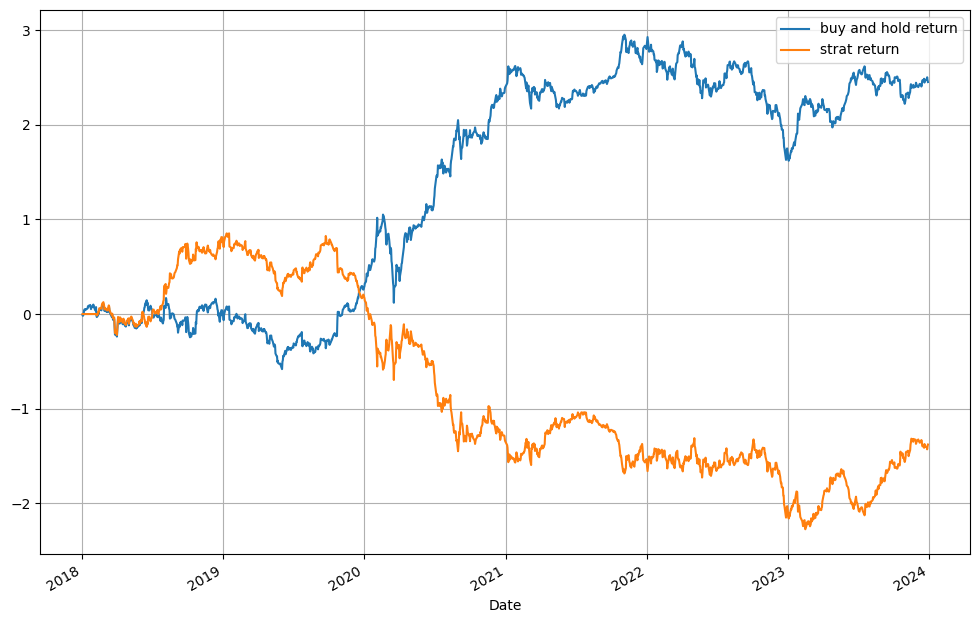

In [46]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold return:",df['buy and hold return'].cumsum()[-1])
print("Strategy return:",df['strat return'].cumsum()[-1])

# strategy historical performance plotting
df[['buy and hold return','strat return']] = df[['buy and hold return','strat return']].cumsum()
df[['buy and hold return','strat return']].plot(grid=True, figsize=(12, 8))

**VII Analysis**

We use the pyfolio library for performance and risk analysis of the strategy returns.

c:\Users\odend\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-35.126%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2018-01-02
End date,2023-12-29
Total months,71
,Backtest
Annual return,-35.126%
Cumulative returns,-92.507%
Annual volatility,63.503%
Sharpe ratio,-0.36
Calmar ratio,-0.36
Stability,0.87
Max drawdown,-98.304%


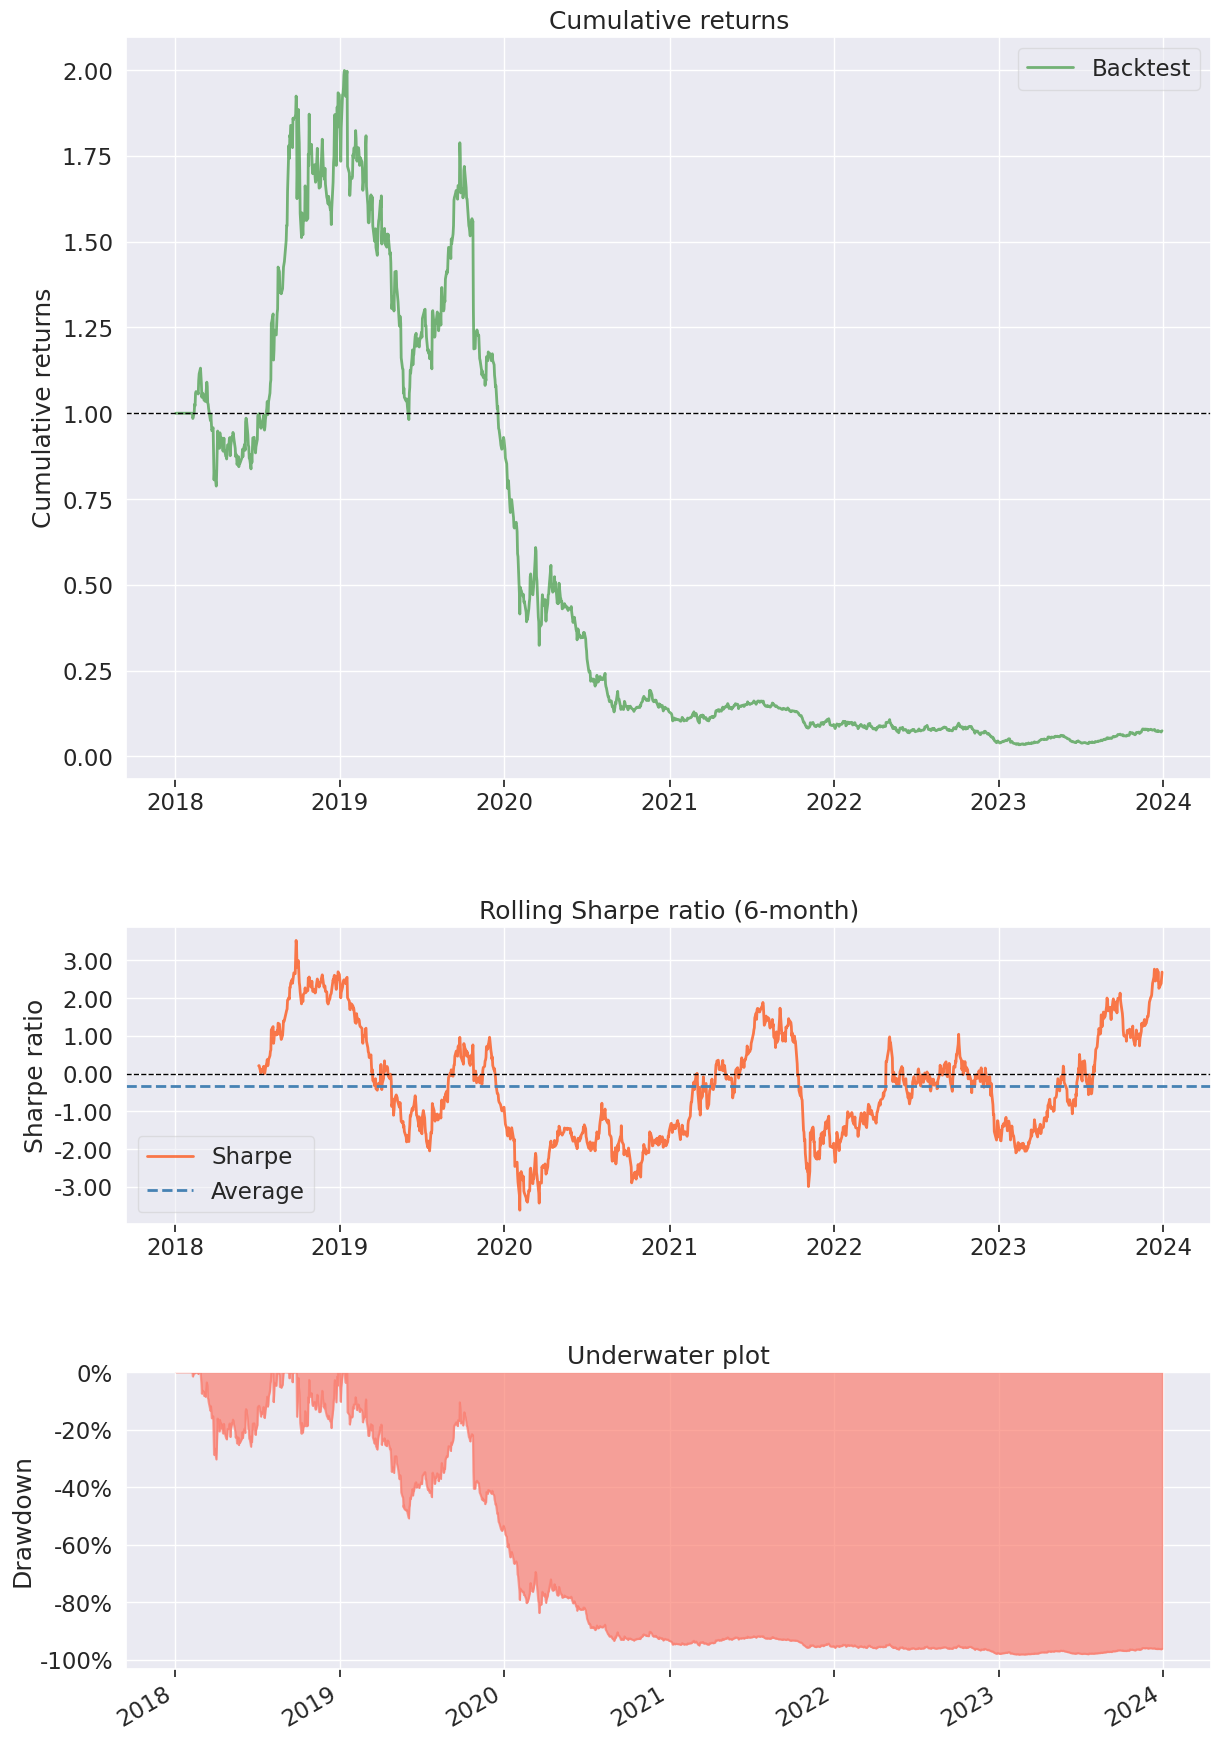

In [47]:
pf.create_simple_tear_sheet(df['strat return'].diff())

**Conclusion**

On the long run, the Bollinger band strategy on the historical data underperformed the buy & hold strategy. It displayed extremely poor cumulative returns (-92.507%) with high annual volatility (63.503%), and a max drawdown of -98.304%. One possible explanation is that selling a stock when it appears to be 'overbought' is not a reliable strategy as it goingon a crazy surge like TSLA did from late 2019 to late 2021. 

However, as the stock was struggling to generate positive returns between 2018 and late 2019, the strategy overperformed. A less volatile stock price seems to be a better environment to implement a Bollinger band strategy.